In [15]:
import numpy as np
import os
import shutil
import pathlib
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50V2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [16]:
## Data Preparation
# Define dataset parameters
DATASET_PATH = "./wildlife-animals-images/"
WORKING_DIR = "./tmp/"
IMG_SIZE = (224, 224)  # Standard size for pre-trained models
BATCH_SIZE = 32
EPOCHS = 70
ANIMAL_CLASSES = ["fox", "cheetah", "hyena", "lion", "tiger", "wolf"]
HABITAT_MAP = {
    "lion": "Savannah",
    "tiger": "Rainforest",
    "cheetah": "Grasslands",
    "fox": "Forests",
    "wolf": "Tundra",
    "hyena": "Savannah"
}

In [17]:
# Test images to predict
TEST_IMAGES = [
    r"C:\Users\91924\datasets\wildlife-animals-images\fox\00000028_300resized.png",
    r"C:\Users\91924\datasets\wildlife-animals-images\cheetah\00000138_300resized.png",
    r"C:\Users\91924\datasets\wildlife-animals-images\wolf\00000032_300resized.png"
]

In [18]:
# Prepare dataset directory structure
def prepare_dataset():
    os.makedirs(WORKING_DIR, exist_ok=True)
    
    # Copy images to working directory (organized by class)
    for animal in ANIMAL_CLASSES:
        os.makedirs(os.path.join(WORKING_DIR, animal), exist_ok=True)
        source_folder = os.path.join(DATASET_PATH, f"{animal}-resize-300")
        
        if os.path.exists(source_folder):
            for img_file in os.listdir(source_folder):
                if img_file.endswith(".png"):
                    shutil.copy(os.path.join(source_folder, img_file), 
                               os.path.join(WORKING_DIR, animal))

    # Remove known corrupted images
    corrupt_images = [
        "tmp/hyena/00000224_300resized.png",
        "tmp/cheetah/00000244_300resized.png"
    ]
    
    for img in corrupt_images:
        if os.path.exists(img):
            os.remove(img)

    # Split dataset into train/val/test
    splitfolders.ratio(WORKING_DIR, output='dataset_split', 
                      seed=1234, ratio=(0.7, 0.15, 0.15))

In [19]:
# Prepare data generators
def create_data_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        'dataset_split/train',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=True
    )
    
    val_generator = val_test_datagen.flow_from_directory(
        'dataset_split/val',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False
    )
    
    test_generator = val_test_datagen.flow_from_directory(
        'dataset_split/test',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False
    )
    
    return train_generator, val_generator, test_generator

In [20]:
def build_pretrained_model(base_model_name):
    # Create base model - FIXED THE SYNTAX ERROR HERE
    if base_model_name == "MobileNetV2":
        base_model = MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    elif base_model_name == "EfficientNetB0":
        base_model = EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    elif base_model_name == "ResNet50V2":
        base_model = ResNet50V2(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    else:
        raise ValueError("Unsupported model name")
    
    base_model.trainable = False
    
    inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(len(ANIMAL_CLASSES), activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [25]:
def predict_test_images(model):
    """Predict and display results for the test images"""
    plt.figure(figsize=(15, 5))
    
    for i, image_path in enumerate(TEST_IMAGES):
        # Load and preprocess image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not read image at {image_path}")
            continue
        
        img = cv2.resize(img, IMG_SIZE)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        input_img = img_rgb / 255.0
        input_img = np.expand_dims(input_img, axis=0)
        
        # Predict
        predictions = model.predict(input_img)
        predicted_class = np.argmax(predictions, axis=1)[0]
        confidence = np.max(predictions) * 100
        
        # Get class labels
        class_indices = {i: cls for i, cls in enumerate(ANIMAL_CLASSES)}
        predicted_animal = class_indices[predicted_class]
        predicted_habitat = HABITAT_MAP.get(predicted_animal, "Unknown")
        
        # Display the image with prediction
        plt.subplot(1, 3, i+1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_animal}\nHabitat: {predicted_habitat}\nConfidence: {confidence:.2f}%")

    plt.tight_layout()
    plt.show()

In [21]:
def train_model(model, train_data, val_data, model_name):
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    callbacks = [
        ModelCheckpoint(
            f'{model_name}_best.weights.h5',  # Changed to include .weights.h5
            save_best_only=True,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max'
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
    
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks
    )
    
    return history

In [22]:
## Evaluation and Prediction
def evaluate_model(model, test_data):
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_data)
    print(f"\nTest Accuracy: {test_acc * 100:.2f}%")
    
    # Classification report
    test_data.reset()
    y_pred = model.predict(test_data)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = test_data.classes
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=ANIMAL_CLASSES))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=ANIMAL_CLASSES,
                yticklabels=ANIMAL_CLASSES)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return test_acc

In [23]:
def predict_animal_habitat(model, image_path):
    # Load and preprocess image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return None, None, None
    
    img = cv2.resize(img, IMG_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Predict
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions) * 100
    
    # Get class labels
    class_indices = {i: cls for i, cls in enumerate(ANIMAL_CLASSES)}
    animal = class_indices[predicted_class]
    habitat = HABITAT_MAP.get(animal, "Unknown")
    
    # Display results
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Animal: {animal}\nHabitat: {habitat}\nConfidence: {confidence:.2f}%")
    plt.show()
    
    return animal, habitat, confidence


opying files: 1723 files [00:02, 667.52 files/s]

Found 1204 images belonging to 6 classes.
Found 256 images belonging to 6 classes.
Found 263 images belonging to 6 classes.


C:\Users\91924\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
C:\Users\91924\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/70
38/38 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.3177 - loss: 1.8256 - val_accuracy: 0.9531 - val_loss: 0.5882 - learning_rate: 1.0000e-04
Epoch 2/70
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8113 - loss: 0.6834 - val_accuracy: 0.9844 - val_loss: 0.2560 - learning_rate: 1.0000e-04
Epoch 3/70
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 923ms/step - accuracy: 0.9120 - loss: 0.4012 - val_accuracy: 0.9883 - val_loss: 0.1544 - learning_rate: 1.0000e-04
Epoch 4/70
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 877ms/step - accuracy: 0.9252 - loss: 0.2852 - val_accuracy: 0.9844 - val_loss: 0.1156 - learning_rate: 1.0000e-04
Epoch 5/70
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9375 - loss: 0.2157 - val_accuracy: 0.9844 - val_loss: 0.0970 - learning_rate: 1.0000e-04
Epoch 6/70
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9378 - loss: 0.2082 - val_accuracy: 0.9844 - val_loss: 0.0839 - learning_rate: 1.0000e-04
Epoch 7/70
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 898ms/step - accuracy: 0.954

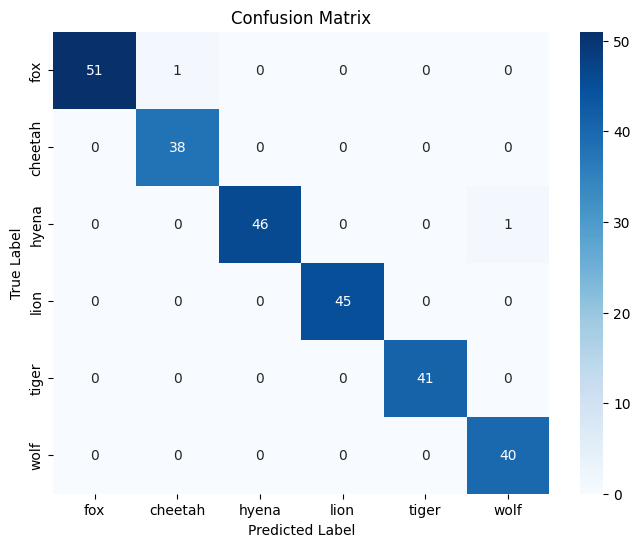

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


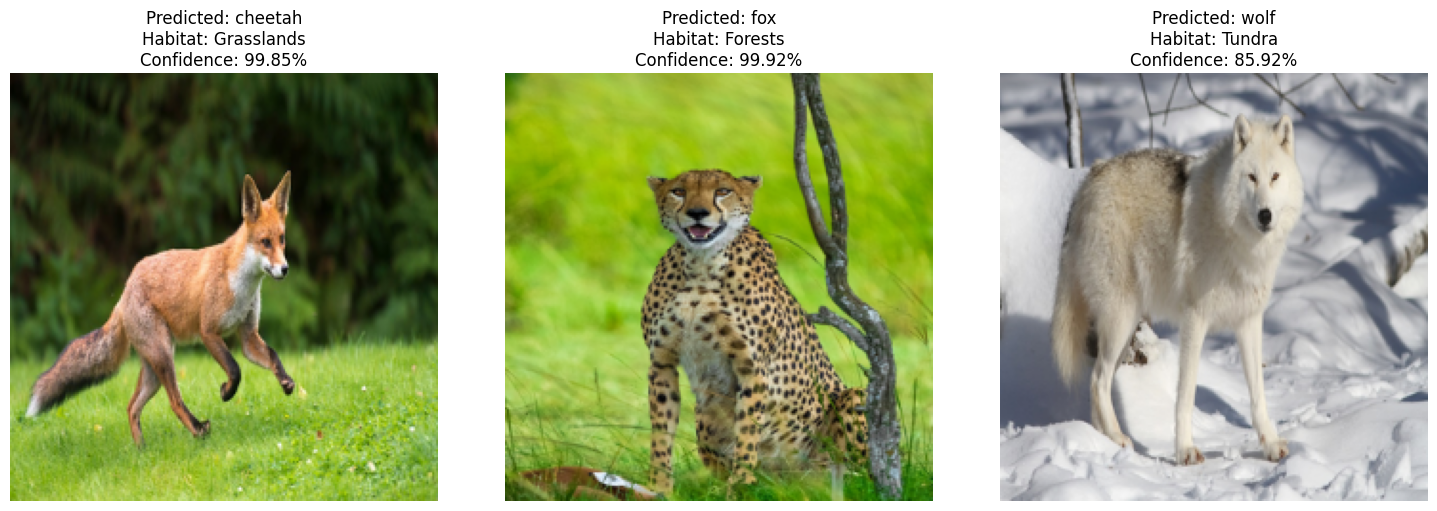

In [26]:
def main():
    """Main execution function"""
    # Prepare data
    prepare_dataset()
    train_gen, val_gen, test_gen = create_data_generators()
    
    # Select model (change as needed)
    MODEL_NAME = "MobileNetV2"  # Options: "MobileNetV2", "EfficientNetB0", "ResNet50V2"
    
    # Build and train model
    model = build_pretrained_model(MODEL_NAME)
    history = train_model(model, train_gen, val_gen, MODEL_NAME)
    
    # Evaluate
    test_accuracy = evaluate_model(model, test_gen)
    
    # Predict on our test images
    predict_test_images(model)

if __name__ == "__main__":
    main()